In this file, we demonstrate the training and usage of SURE. Before running the example code in this file, please prepare the data according to the process described in the previous file.

First, we use the shell to invoke commands to train the SURE model. In the following command:
- `--data-file` is used to specify the file containing the single-cell transcriptome data. It can be a csv or tsv file, where rows represent cells and columns represent genes. Do not set row names for each row, meaning there is no need to set an index.
- `--undesired-factor-file` is used to specify the file containing the undesired factor values. Undesired factors can be batch, sample, or any other factors that you wish to remove from the data. Users can set the undesired factors based on their actual problem requirements.
- `--jit` is used to enable Jax acceleration. It is worth noting that if users want to use this feature, both `--data-file` and `--undesired-factor-file` need to be provided. If the user only sets `--data-file` and uses `--jit`, the program will encounter an error.
- `-cd` is used to set the number of metacells.
- `-lr` is the learning rate.
- `-n` is the number of epochs.
- `-bs` is the batch size.
- `-zi exact` is used to specify the exact form of the zero-inflated model.
- `-likeli negbinomial` is used to specify the negative binomial distribution model for calculating the data likelihood.

In [12]:
%%bash

CUDA_VISIBLE_DEVICES=0  python SURE.py --data-file "/home/oem/SURE_example_3/human_brain_secondary_counts.txt.gz" \
                        --undesired-factor-file "/home/oem/SURE_example_3/human_brain_secondary_uwv.txt.gz" \
                        --jit \
                        -rt \
                        -cd 200 \
                        -lr 0.0001 \
                        -n 300 \
                        -bs 1000 \
                        --seed 0 \
                        --cuda \
                        -zi exact \
                        -likeli negbinomial \
                        --save-model "sure_4_neurips21_secondary.pth" 2>&1 | tee "sure_4_neurips21_secondary.log"

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
1 epoch: avg losses 77712026.2314 elapsed 16.8637 seconds
2 epoch: avg losses 66920401.3554 elapsed 2.2498 seconds
3 epoch: avg losses 64704399.0413 elapsed 2.2264 seconds
4 epoch: avg losses 63650348.8595 elapsed 2.2370 seconds
5 epoch: avg losses 63004480.3802 elapsed 2.2324 seconds
6 epoch: avg losses 62560594.5785 elapsed 2.2090 seconds
7 epoch: avg losses 62237308.8430 elapsed 2.3735 seconds
8 epoch: avg losses 61985109.0579 elapsed 2.2625 seconds
9 epoch: avg losses 61780455.8182 elapsed 2.1843 seconds
10 epoch: avg losses 61605384.3636 elapsed 2.2328 seconds
11 epoch: avg losses 61452220.9256 elapsed 2.3211 seconds
12 epoch: avg losses 61316828.2975 elapsed 2.2809 seconds
13 epoch: avg losses 61188984.9421 elapsed 2.1882 seconds
14 epoch: avg losses 61070

Set up the Python environment and load some necessary packages.

Here, we use R for plotting, so we need to use [rpy2](https://rpy2.github.io/). If users want to try running these R code snippets, they need to install these Python packages. If there is no need to run these R code snippets, please ignore them directly.

In [13]:

import numpy as np
import pandas as pd

from SURE import SURE
from utils.scdata_cached import setup_data_loader, SingleCellCached

import torch
from torch.utils.data import DataLoader

import datatable as dt


# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks

pandas2ri.activate()

%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [14]:

ModelPath = 'sure_4_neurips21_secondary.pth'
DataPath='/home/oem/SURE_example_3/human_brain_secondary_counts.txt.gz'


In [15]:
# load model
model = torch.load(ModelPath)

batch_size = 10000

use_float64 = False
use_cuda = True
log_trans = False

In [16]:
# load data
data_cached = SingleCellCached(DataPath, None, log_trans=log_trans, use_cuda=False, use_float64 = use_float64)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = False)

#### Get the latent representations of primary metacells

In [17]:
embeds = []
weights = []

for xs1,ks2 in data_loader:
    if use_cuda:
        xs1 = xs1.cuda()

    zs = model.get_cell_coordinates(xs1)
    ws = model.soft_assignments(xs1)
    
    if use_cuda:
        zs = zs.cpu().detach().numpy()
        ws = ws.cpu().detach().numpy()
    else:
        zs = zs.detach().numpy()
        ws = ws.detach().numpy()

    embeds.append(zs)
    weights.append(ws)

embeds = np.concatenate(embeds, axis=0)
weights = np.concatenate(weights, axis=0)


cells = pd.read_csv('/home/oem/SURE_example_3/human_brain_secondary_cell.csv.gz', header=0)
genes = pd.read_csv('/home/oem/SURE_example_3/human_brain_secondary_gene.csv.gz', header=0)

df = pd.DataFrame(embeds, index=cells.iloc[:,0].values).reset_index()
dt.Frame(df).to_csv('/home/oem/SURE_example_3/human_brain_secondary_embeds.csv.gz')

df=pd.DataFrame(weights, index=cells.iloc[:,0].values)
dt.Frame(df.reset_index()).to_csv('/home/oem/SURE_example_3/human_brain_secondary_weights.csv.gz')

#### Get the latent representations of secondary metacells

In [18]:
codebook=model.get_metacell_coordinates().cpu().detach().numpy()
pd.DataFrame(codebook).to_csv('/home/oem/SURE_example_3/human_brain_secondary_codebook.csv.gz')

#### Load H5AD files

In [19]:
import scanpy as sc

adata = sc.read_h5ad('/home/oem/SURE_example_3/human_brain_primary_metacells.h5ad')
meta = adata.obs

#### Invoke R to plot and display the latent representations of primary metacells and secondary metacells.

In [20]:
%%R -i meta 

library(Seurat)
library(dplyr)
library(useful)
library(data.table)
library(ggplot2)
library(cowplot)
library(uwot)

set.seed(123)

scp <- fread('/home/oem/SURE_example_3/human_brain_secondary_embeds.csv.gz', data.table = FALSE, header = TRUE)
rownames(scp) <- scp[,1]
scp <- scp[,-1]

embed.list <- umap(scp, n_threads = 40, pca=NULL, ret_model = TRUE)
embed <- embed.list$embedding
colnames(embed) <- c('UMAP_1','UMAP_2')



recon <- CreateSeuratObject(scp[,1:5] %>% as.matrix %>% t, meta.data = meta[rownames(scp),])
recon[['umap']] <- CreateDimReducObject(embed %>% as.matrix(), key = 'UMAP_')

In addition: Warning message:
No assay specified, setting assay as RNA by default. 


In [21]:
%%R 

codebook <- read.csv('/home/oem/SURE_example_3/human_brain_secondary_codebook.csv.gz', row.names = 1)
embed_cb <- umap_transform(codebook, embed.list) %>% as.data.frame()
colnames(embed_cb) <- c('UMAP_1','UMAP_2')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`


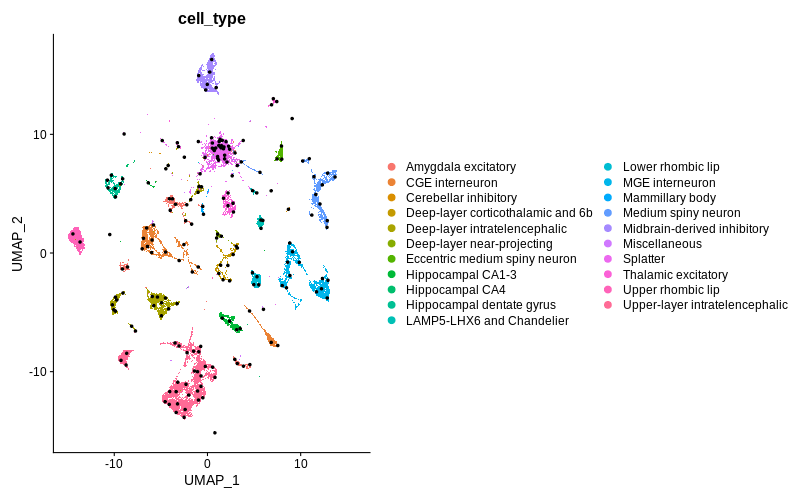

In [22]:
%%R -w 800 -h 500 -u px

plt <- DimPlot(recon, reduction = 'umap', group.by = 'cell_type', label=FALSE, repel=TRUE)
plt + geom_point(data = embed_cb, aes(UMAP_1,UMAP_2), size=1)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`


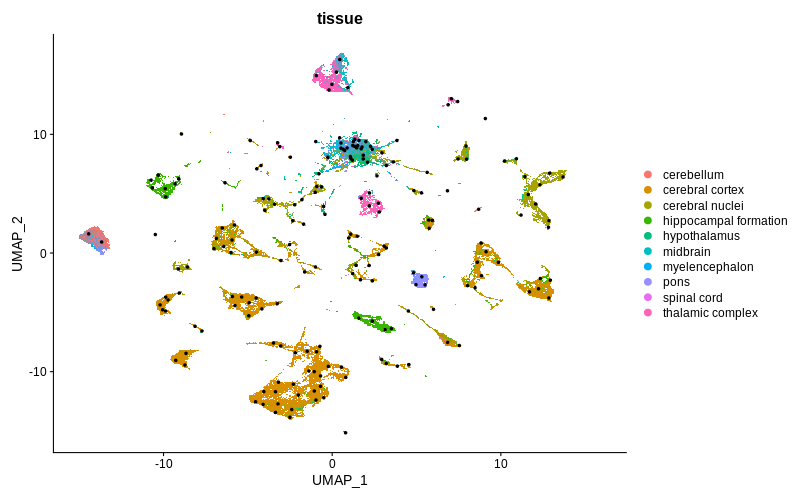

In [23]:
%%R -w 800 -h 500 -u px

plt <- DimPlot(recon, reduction = 'umap', group.by = 'tissue', label=FALSE, repel=TRUE)
plt + geom_point(data = embed_cb, aes(UMAP_1,UMAP_2), size=1)